In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [2]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

'''
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
'''

# 데이터 개수: 3670개 / 클래스당 폴더 하나씩


228827136/228813984 [==============================] - 2s 0us/step
3670


'\nflower_photo/\n  daisy/\n  dandelion/\n  roses/\n  sunflowers/\n  tulips/\n'

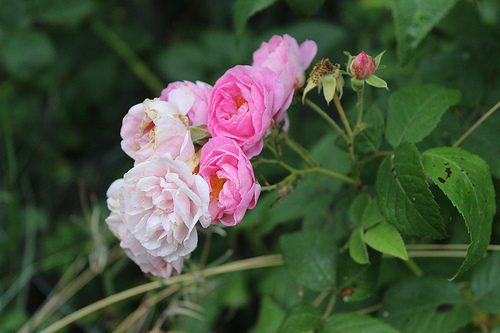

In [3]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

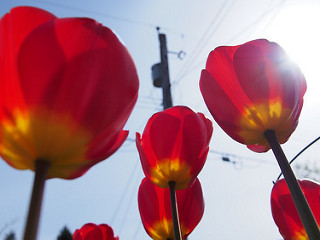

In [4]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

In [5]:
# 기본 설정값
batch_size = 32
img_height = 180
img_width = 180

# 80% 데이터를 학습에 사용
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# 20% 데이터를 검증에 사용
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


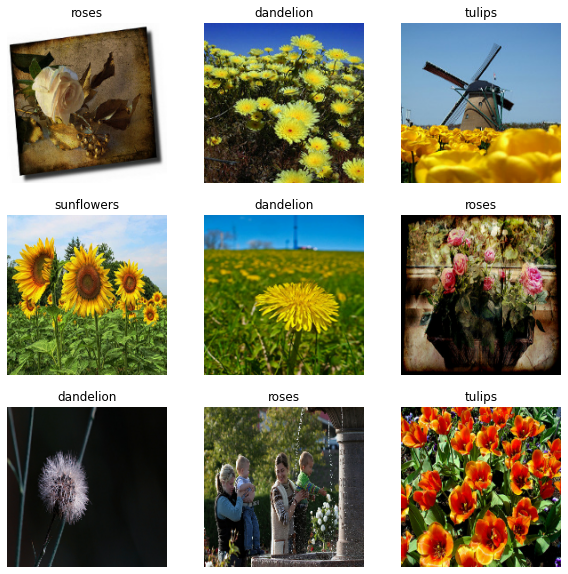

In [6]:
import matplotlib.pyplot as plt

# 데이터 샘플 확인
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
# 배치 데이터 확인하는 방법
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 3)
(32,)


In [9]:
# 성능 향상: 버퍼링된 프리페치를 사용하여 I/O를 차단하지 않고 디스크에서 데이터를 생성할 수 있도록 만들기
# Dataset.cache()는 첫 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 
#                   이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 
#                   데이터세트가 너무 커서 메모리에 맞지 않는 경우, 
#                   이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다.
# Dataset.prefetch()는 훈련 중에 데이터 전처리 및 모델 실행과 겹칩니다.

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
# 데이터 정규화 : 0~255 -> 0~1로 리스케일링하는 또다른 방법(keras)
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [11]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [14]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 94s 1s/step - loss: 1.3174 - accuracy: 0.4486 - val_loss: 1.0848 - val_accuracy: 0.5681
Epoch 2/10
92/92 [==============================] - 92s 1s/step - loss: 0.9714 - accuracy: 0.6240 - val_loss: 0.9691 - val_accuracy: 0.6253
Epoch 3/10
92/92 [==============================] - 92s 995ms/step - loss: 0.8036 - accuracy: 0.6972 - val_loss: 0.9246 - val_accuracy: 0.6471
Epoch 4/10
92/92 [==============================] - 92s 1s/step - loss: 0.5911 - accuracy: 0.7796 - val_loss: 0.9591 - val_accuracy: 0.6485
Epoch 5/10
92/92 [==============================] - 92s 1s/step - loss: 0.4027 - accuracy: 0.8587 - val_loss: 0.9766 - val_accuracy: 0.6471
Epoch 6/10
92/92 [==============================] - 92s 1s/step - loss: 0.2397 - accuracy: 0.9196 - val_loss: 1.3096 - val_accuracy: 0.6390
Epoch 7/10
92/92 [==============================] - 92s 1s/step - loss: 0.1323 - accuracy: 0.9605 - val_loss: 1.3430 - val_accuracy: 0.6253
Epoch 8/10
92/92 

In [ ]:
# 학습 결과 시각화 = 오버피팅이 발생한 것을 확인할 수 있음

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
# 데이터 증강(data augmentation)
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
# 데이터 증강 결과 시각화
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation, # 데이터 증강
  layers.experimental.preprocessing.Rescaling(1./255), # 스케일링
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), # 드롭아웃
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 94s 1s/step - loss: 1.2961 - accuracy: 0.4401 - val_loss: 1.0737 - val_accuracy: 0.5436
Epoch 2/15
92/92 [==============================] - 92s 999ms/step - loss: 0.9804 - accuracy: 0.6073 - val_loss: 0.9853 - val_accuracy: 0.6090
Epoch 3/15
92/92 [==============================] - 92s 998ms/step - loss: 0.8833 - accuracy: 0.6509 - val_loss: 0.9418 - val_accuracy: 0.6390
Epoch 4/15
92/92 [==============================] - 92s 997ms/step - loss: 0.8234 - accuracy: 0.6846 - val_loss: 0.8385 - val_accuracy: 0.6676
Epoch 5/15
92/92 [==============================] - 92s 998ms/step - loss: 0.7885 - accuracy: 0.6924 - val_loss: 0.8243 - val_accuracy: 0.6921
Epoch 6/15
92/92 [==============================] - 92s 998ms/step - loss: 0.7471 - accuracy: 0.7108 - val_loss: 0.8440 - val_accuracy: 0.6540
Epoch 7/15
92/92 [==============================] - 92s 996ms/step - loss: 0.7194 - accuracy: 0.7272 - val_loss: 0.7738 - val_accuracy: 0.6866
Ep

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# train/validation 데이터에 포함되지 않은 새로운 이미지 분류

sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)